"""
📘 Project: Detecting AI-Generated Text with BERT
👤 Author: YI LUO
📅 Date: 2025-04-02

🔗 Dataset Source:
Kaggle Competition - "LLM: Detect AI-Generated Text"  
https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data

🧠 Objective:
This project aims to build a binary classifier that can distinguish between human-written and AI-generated short essays using pre-trained transformer models (e.g., BERT).

📊 Data Summary:
- Training set includes ~1,378 short essays, each labeled as:
  - `0`: Human-written
  - `1`: AI-generated
- A supplemental file (`train_prompts.csv`) provides metadata including:
  - Prompt topic, source text, and writing instructions
- The dataset is **highly imbalanced**, with only **3 AI-generated** samples.

🧪 What We Did:
1. **Merged essay text with prompt metadata** to enrich model input
2. **Explored label distribution** and identified extreme imbalance
3. **Visualized prompt usage** to understand data context diversity
4. **Preprocessed data** using HuggingFace tokenizer (`bert-base-uncased`)
5. **Fine-tuned a BERT classifier** using PyTorch and BCE loss
6. **Evaluated performance** on a validation set (accuracy reported)
7. **Predicted on test data** and formatted submission for Kaggle

📈 Key Insights:
- The dataset is not only small but also extremely skewed (~0.2% positive class)
- Prompt metadata may provide additional semantic cues helpful for classification
- 100% accuracy on validation set is misleading and likely reflects imbalance, not generalization

📦 Output:
- Predictions saved to: `submission.csv`
- Ready for submission to Kaggle or review in a real-world model evaluation pipeline

This notebook serves as a complete and reproducible example of how to approach a text classification task with BERT, featuring clean structure and documentation for portfolio-quality presentation.
"""

In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ⚙️ Display settings
pd.set_option('display.max_colwidth', 200)
sns.set(style="whitegrid")

# ✅ Load data
essays = pd.read_csv("/Users/luoyi/Desktop/10_kaggle/06_llm-detect-ai-generated-text/train_essays.csv")
prompts = pd.read_csv("/Users/luoyi/Desktop/10_kaggle/06_llm-detect-ai-generated-text/train_prompts.csv")

# Rename label column for consistency
essays.rename(columns={"generated": "label"}, inplace=True)

# 📌 Merge prompt metadata
df = essays.merge(prompts, on="prompt_id", how="left")

# 🧠 Construct input text (instruction + essay text)
df["input_text"] = "[PROMPT] " + df["instructions"] + " [ESSAY] " + df["text"]

# 🔍 Show example
df[["input_text", "label"]].head()

,input_text,label
0,[PROMPT] Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Ma...,0
1,[PROMPT] Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Ma...,0
2,[PROMPT] Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Ma...,0
3,[PROMPT] Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Ma...,0
4,[PROMPT] Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Ma...,0


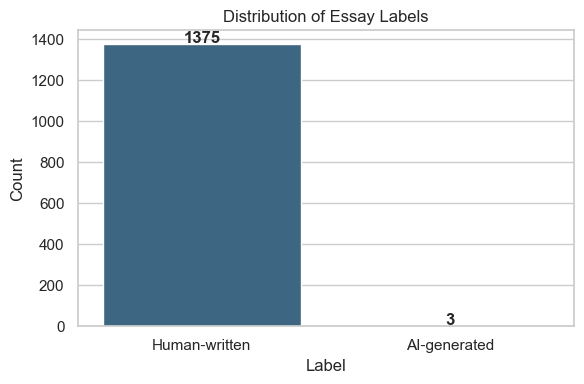

⚠️ Only 0.22% of samples are AI-generated. Consider balancing during training.

📝 Top 5 Most Frequent Prompts:
prompt_name
Car-free cities                     708
Does the electoral college work?    670
Name: count, dtype: int64


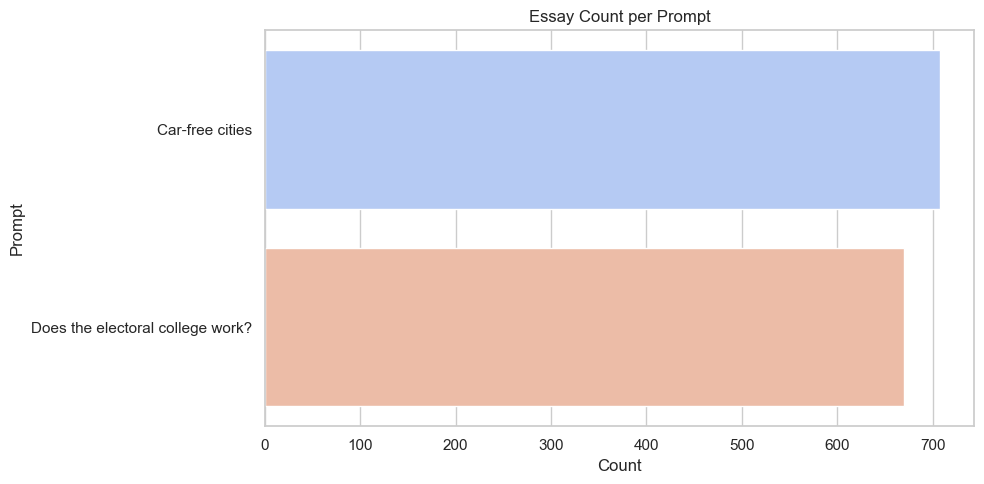

In [2]:
# 📊 Count label distribution
label_counts = df['label'].value_counts().sort_index()
label_names = ['Human-written', 'AI-generated']

# 📈 Plot class imbalance
plt.figure(figsize=(6,4))
sns.barplot(x=label_names, y=label_counts.values, palette="viridis")
plt.title("Distribution of Essay Labels")
plt.ylabel("Count")
plt.xlabel("Label")
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 5, str(count), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# 🧠 Insight: Check proportion of AI-generated
ai_ratio = label_counts[1] / label_counts.sum()
print(f"⚠️ Only {ai_ratio:.2%} of samples are AI-generated. Consider balancing during training.")

# 📚 Prompt usage statistics
prompt_counts = df['prompt_name'].value_counts()
print("\n📝 Top 5 Most Frequent Prompts:")
print(prompt_counts.head())

# 📈 Plot prompt frequency
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='prompt_name', order=prompt_counts.index, palette='coolwarm')
plt.title("Essay Count per Prompt")
plt.xlabel("Count")
plt.ylabel("Prompt")
plt.tight_layout()
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# ✅ Stratified train/val split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["input_text"].tolist(),
    df["label"].tolist(),
    test_size=0.1,
    stratify=df["label"],
    random_state=42
)

print(f"📚 Train samples: {len(train_texts)}, Validation samples: {len(val_texts)}")

# ✅ Load tokenizer (you can swap in e.g., 'albert-base-v2',  "bert-base-uncased")
model_name = 'albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Custom PyTorch Dataset
class EssayDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# ✅ Wrap into DataLoaders
batch_size = 4
train_ds = EssayDataset(train_texts, train_labels, tokenizer)
val_ds = EssayDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

print("✅ Tokenization & DataLoaders ready.")

📚 Train samples: 1240, Validation samples: 138
✅ Tokenization & DataLoaders ready.


In [4]:
import torch.nn as nn
from transformers import AutoModel, AutoConfig, AdamW

# ✅ Detect device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"📡 Using device: {device}")

# ✅ Model definition
class BERTClassifier(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name, config=config)
        self.classifier = nn.Linear(config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0]  # use [CLS] token
        logits = self.classifier(cls_token)
        return logits

# ✅ Initialize model
model = BERTClassifier(model_name).to(device)

# ✅ Loss function (binary classification)
loss_fn = nn.BCEWithLogitsLoss()

# ✅ Optimizer (AdamW is standard for transformers)
optimizer = AdamW(model.parameters(), lr=2e-5)

📡 Using device: mps


In [5]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# ✅ Training loop
print("🚀 Starting training...")
model.train()
for epoch in range(1):  # You can increase to 3+ for better results
    loop = tqdm(train_loader, total=len(train_loader))
    for step, batch in enumerate(loop):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        logits = model(input_ids, attention_mask).view(-1)
        loss = loss_fn(logits, labels)

        # Backprop + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
        if (step + 1) % 10 == 0:
            print(f"🧠 Step {step+1} | Loss: {loss.item():.4f}")

print("✅ Training finished!")

# ✅ Validation
print("\n🧪 Running validation...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].cpu().numpy()

        logits = model(input_ids, attention_mask).view(-1)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_preds.extend(preds)
        all_labels.extend(labels)

# ✅ Compute accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Validation Accuracy: {acc:.4f}")

🚀 Starting training...


Epoch 0:   3%|▌                 | 10/310 [00:03<01:32,  3.23it/s, loss=0.000681]

🧠 Step 10 | Loss: 0.0007


Epoch 0:   6%|█▏                | 20/310 [00:06<01:29,  3.26it/s, loss=0.000249]

🧠 Step 20 | Loss: 0.0002


Epoch 0:  10%|█▋                | 30/310 [00:09<01:36,  2.90it/s, loss=0.000115]

🧠 Step 30 | Loss: 0.0001


Epoch 0:  13%|██▍                | 40/310 [00:12<01:23,  3.25it/s, loss=0.00225]

🧠 Step 40 | Loss: 0.0023


Epoch 0:  16%|███                | 50/310 [00:15<01:19,  3.26it/s, loss=0.00756]

🧠 Step 50 | Loss: 0.0076


Epoch 0:  19%|███▋               | 60/310 [00:19<01:24,  2.96it/s, loss=0.00179]

🧠 Step 60 | Loss: 0.0018


Epoch 0:  23%|████              | 70/310 [00:22<01:17,  3.11it/s, loss=0.000987]

🧠 Step 70 | Loss: 0.0010


Epoch 0:  26%|████▋             | 80/310 [00:25<01:10,  3.27it/s, loss=0.000549]

🧠 Step 80 | Loss: 0.0005


Epoch 0:  29%|█████▏            | 90/310 [00:28<01:11,  3.08it/s, loss=0.000419]

🧠 Step 90 | Loss: 0.0004


Epoch 0:  32%|█████▊            | 100/310 [00:32<01:06,  3.18it/s, loss=0.00862]

🧠 Step 100 | Loss: 0.0086


Epoch 0:  35%|██████▍           | 110/310 [00:35<01:01,  3.23it/s, loss=0.00825]

🧠 Step 110 | Loss: 0.0083


Epoch 0:  39%|██████▉           | 120/310 [00:38<01:01,  3.11it/s, loss=0.00227]

🧠 Step 120 | Loss: 0.0023


Epoch 0:  42%|████████▍           | 130/310 [00:41<00:57,  3.14it/s, loss=0.001]

🧠 Step 130 | Loss: 0.0010


Epoch 0:  45%|███████▋         | 140/310 [00:44<00:51,  3.29it/s, loss=0.000603]

🧠 Step 140 | Loss: 0.0006


Epoch 0:  48%|████████▏        | 150/310 [00:47<00:49,  3.23it/s, loss=0.000444]

🧠 Step 150 | Loss: 0.0004


Epoch 0:  52%|████████▊        | 160/310 [00:50<00:51,  2.94it/s, loss=0.000346]

🧠 Step 160 | Loss: 0.0003


Epoch 0:  55%|██████████▉         | 170/310 [00:54<00:43,  3.22it/s, loss=0.013]

🧠 Step 170 | Loss: 0.0130


Epoch 0:  58%|██████████▍       | 180/310 [00:57<00:39,  3.27it/s, loss=0.00518]

🧠 Step 180 | Loss: 0.0052


Epoch 0:  61%|███████████       | 190/310 [01:00<00:38,  3.10it/s, loss=0.00247]

🧠 Step 190 | Loss: 0.0025


Epoch 0:  65%|███████████▌      | 200/310 [01:03<00:34,  3.21it/s, loss=0.00136]

🧠 Step 200 | Loss: 0.0014


Epoch 0:  68%|███████████▌     | 210/310 [01:06<00:30,  3.24it/s, loss=0.000994]

🧠 Step 210 | Loss: 0.0010


Epoch 0:  71%|████████████     | 220/310 [01:09<00:27,  3.25it/s, loss=0.000762]

🧠 Step 220 | Loss: 0.0008


Epoch 0:  74%|████████████▌    | 230/310 [01:12<00:25,  3.18it/s, loss=0.000644]

🧠 Step 230 | Loss: 0.0006


Epoch 0:  77%|█████████████▏   | 240/310 [01:16<00:21,  3.23it/s, loss=0.000544]

🧠 Step 240 | Loss: 0.0005


Epoch 0:  81%|█████████████▋   | 250/310 [01:19<00:18,  3.26it/s, loss=0.000455]

🧠 Step 250 | Loss: 0.0005


Epoch 0:  84%|██████████████▎  | 260/310 [01:22<00:16,  3.05it/s, loss=0.000425]

🧠 Step 260 | Loss: 0.0004


Epoch 0:  87%|██████████████▊  | 270/310 [01:25<00:12,  3.17it/s, loss=0.000377]

🧠 Step 270 | Loss: 0.0004


Epoch 0:  90%|███████████████▎ | 280/310 [01:28<00:09,  3.25it/s, loss=0.000347]

🧠 Step 280 | Loss: 0.0003


Epoch 0:  94%|████████████████▊ | 290/310 [01:31<00:07,  2.80it/s, loss=0.00032]

🧠 Step 290 | Loss: 0.0003


Epoch 0:  97%|████████████████▍| 300/310 [01:35<00:03,  3.26it/s, loss=0.000293]

🧠 Step 300 | Loss: 0.0003


Epoch 0: 100%|█████████████████| 310/310 [01:38<00:00,  3.16it/s, loss=0.000272]


🧠 Step 310 | Loss: 0.0003
✅ Training finished!

🧪 Running validation...
✅ Validation Accuracy: 1.0000


In [6]:
# 📄 Load test file
test_df = pd.read_csv("/Users/luoyi/Desktop/10_kaggle/06_llm-detect-ai-generated-text/test_essays.csv")
test_texts = test_df["text"].tolist()
ids = test_df["id"].tolist()

# ✅ Create test dataset
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze()
        }

# ✅ Wrap in DataLoader
test_ds = TestDataset(test_texts, tokenizer)
test_loader = DataLoader(test_ds, batch_size=4)

# ✅ Predict
model.eval()
pred_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        logits = model(input_ids, attention_mask).view(-1)
        probs = torch.sigmoid(logits).cpu().numpy()
        pred_probs.extend(probs)

# ✅ Save as submission.csv
sub_df = pd.DataFrame({"id": ids, "generated": pred_probs})
sub_path = "//Users/luoyi/Desktop/10_kaggle/06_llm-detect-ai-generated-text/submission.csv"
sub_df.to_csv(sub_path, index=False)
print(f"📦 Submission saved to: {sub_path}")

📦 Submission saved to: //Users/luoyi/Desktop/10_kaggle/06_llm-detect-ai-generated-text/submission.csv
